<h1>Lab : simplified JPEG encoder/decoder</h1>

# Noms : IMAHO Aladain, HADJ SASSI Mahdi 
# Groupe : 2G1 TP2

# (Faites une copie pour enregistrer vos modifications.)

# Présentation du projet : Réalisation d’un codeur/décodeur JPEG simplifié

JPEG est l’acronyme de Joint Photographic Experts Group. C’est une norme définissant le format d’enregistrement et l’algorithme de décodage pour une représentation numérique compressée d’une image.

JPEG normalise uniquement l’algorithme et le format de décodage. Le processus d’encodage est quant à lui laissé libre à la compétition des industriels et des universitaires. La seule contrainte est que l’image produite doit pouvoir être décodée par un décodeur respectant le standard.

Le format JPEG permet de compresser les données d’une image. Il existe un processus de compression sans pertes (ou réversible) qui permet de revenir exactement aux valeurs de l’image avant encodage. Son taux de compression est inférieur à celui d’une compression avec pertes (ou irréversible). Dans les cas où la taille de l’image est un critère plus important que la qualité, on privilégiera une compression avec pertes.


# I. Structure d'une image (non compressée)

L’image de départ est un tableau de M sur N pixels. Pour une image en niveau de gris, chaque pixel est codé sur un octet (valeurs comprises entre 0 et 255).

Pour une image couleur, chaque pixel est codé sur trois octets, qui représentent les intensités des trois composantes couleur : le rouge, le vert et le bleu.

## Conversion en luminance/chrominance

Une autre représentation que le RGB est souvent utilisée : le YCbCr, qui correspond à la luminance Y (intensité du pixel en niveau de gris) et deux chrominances (une rouge Cr et une bleue Cb). L’image est alors constituée de trois tableaux d’octets, associés respectivement aux trois grandeurs Y, Cr, Cb.

Les formules permettant de passer d’une représentation à l’autre sont les suivantes :

$$ Y = 0.299R + 0.587G + 0.114B $$
$$ Cb = -0.1687R - 0.3313G + 0.5B + 128 $$
$$ Cr = 0.5R - 0.4187G - 0.0813B + 128 $$

$$
R = Y + 1.14020 \times (Cr - 128)
$$

$$
G = Y - 0.34414 \times (Cb - 128) - 0.71414 \times (Cr - 128)
$$

$$
B = Y + 1.77200 \times (Cb - 128)
$$

**Remarque** : $R$, $G$, $B$ sont compris entre 0 et 255. Ces formules peuvent donner des valeurs YCbCr qui sortent de cet intervalle, et qui devront être saturées si nécessaire afin de les garder comprises entre 0 et 255.

Deux formats différents sont fréquemment utilisés :

- Dans le format le plus simple, les trois tableaux Y, Cr, Cb ont les mêmes dimensions, $M$ et $N$, égales aux dimensions de l’image originale.
  
- Un format plus efficace en termes de compression (et donc plus souvent utilisé) consiste à sous-échantillonner les deux signaux de chrominance d’un facteur 2 (ou 4). Plus précisément, avec le facteur 2, le tableau Y reste de taille $[M, N]$ mais les tableaux Cr et Cb sont de dimension $[M/2, N/2]$ (la valeur de chrominance est associée à quatre pixels voisins).

# II. Encodage d'une data unit


Le codeur JPEG travaille sur des *data units*, qui sont des blocs de taille 8x8 pixels d’une image. Chaque composante est découpée en carrés de 8x8 pixels. Si les dimensions de la composante ne sont pas des multiples
de 8, l’image est complétée par duplication de la dernière ligne (ou colonne) jusqu’à obtenir le multiple de 8 immédiatement supérieur. Chaque carré 8x8 est ensuite traité indépendamment, en décrivant l’image de
gauche à droite et de haut en bas.

## II.1. Centrage

 Les échantillons des carrés 8x8 sont des nombres compris entre 0 et 255.  
 La première opération à réaliser est un centrage afin d’obtenir des valeurs comprises entre -128 et 127 (en retirant 128 à chaque valeur).  
 Les valeurs centrées seront notées f(i,j) avec i,j ∈ [0, 7].


## II.2. Transformée en cosinus discrète (DCT)

Après avoir réalisé le centrage, il faut calculer la transformée en cosinus discrète (DCT) de chaque carré 8x8.  
Cette transformation donne une nouvelle matrice 8x8 de coefficients, appelée F(u,v), avec u,v ∈ [0, 7].  

La DCT est une variante de la transformée de Fourier. Elle décompose un bloc, considéré comme une fonction numérique  
à deux variables, en une somme de fonctions cosinus oscillant à des fréquences différentes.  
Chaque bloc est ainsi décrit en une carte de fréquences et en amplitudes plutôt qu’en pixels et coefficients de couleur.  
Pour le décodage, on peut retrouver les $f(i,j)$ à partir de la transformée 2D inverse des $F(u,v)$.

Équations de la DCT et de son inverse :


$$ F(u, v) = C_u C_v \sum_{i=0}^{7} \sum_{j=0}^{7} f(i,j) \cos \left( \frac{(2i + 1) u \pi}{16} \right) \cos \left( \frac{(2j + 1) v \pi}{16} \right) $$

$$ f(i, j) = \sum_{u=0}^{7} \sum_{v=0}^{7} C_u C_v F(u,v) \cos \left( \frac{(2i + 1) u \pi}{16} \right) \cos \left( \frac{(2j + 1) v \pi}{16} \right) $$


avec  $ C_0 = \frac{1}{\sqrt{8}} $ et $ C_u = \frac{1}{2}$  si $ u \neq 0 $.

L’application de la DCT est une opération théoriquement sans perte d’informations : les coefficients initiaux peuvent être retrouvés en appliquant la DCT inverse au résultat de la DCT.  

Ces transformations en deux dimensions sont séparables, car elles peuvent être réalisées en appliquant des transformations en une dimension, successivement sur les lignes et les colonnes.

## II.3. Quantification

La quantification est l'étape qui permet de gagner le plus de place (la DCT n'effectue aucune compression).  
La DCT a retourné, pour chaque bloc, une matrice de 8x8 nombres.  
La quantification consiste à diviser point à point cette matrice par une matrice de quantification également 8x8.  
Soit $ Q $ la matrice de quantification.

Le bloc 8x8 après compression sera obtenu par :

$$
\hat{F}(u, v) = \text{round}\left(\frac{F(u,v)}{Q(u,v)}\right) \tag{3}
$$

Le but est d’atténuer les hautes fréquences car l’œil humain y est très peu sensible. Ces fréquences ont des amplitudes faibles, et elles sont souvent ramenées à 0 après la quantification. Ces coefficients sont situés dans la matrice en bas à droite. Le but va être de ne garder que quelques informations essentielles (concentrées dans le coin en haut à gauche) pour représenter le bloc. Le reste de la matrice sera essentiellement composé de 0, ce qui va permettre d’utiliser un codage **RunLength** afin de gagner de la place.


Les matrices de quantification sont les éléments centraux de la compression avec pertes parce que c’est la
quantification qui permet de régler les pertes, et donc le taux de compression. En toute rigueur, ces matrice
devraient être calculées pour chaque image, en tenant compte du taux de compression désiré et des propriétés
de l’image et de l’oeil. En pratique, ce calcul est complexe, et l’on pourra dans ce projet utiliser les matrices
précalculées.

Pour la quantification d’une composante RGB ou de la composante luminance, la matrice $Q$ est :

| 16  | 11  | 10  | 16  | 24  | 40  | 51  | 61  |
|-----|-----|-----|-----|-----|-----|-----|-----|
| 12  | 12  | 14  | 19  | 26  | 58  | 60  | 55  |
| 14  | 13  | 16  | 24  | 40  | 57  | 69  | 56  |
| 14  | 17  | 22  | 29  | 51  | 87  | 80  | 62  |
| 18  | 22  | 37  | 56  | 68  | 109 | 103 | 77  |
| 24  | 35  | 55  | 64  | 81  | 104 | 113 | 92  |
| 49  | 64  | 78  | 87  | 103 | 121 | 120 | 101 |
| 72  | 92  | 95  | 98  | 112 | 100 | 103 | 99  |

Pour la quantification d’une chrominance, la matrice $Q$ est :

| 17  | 18  | 24  | 47  | 99  | 99  | 99  | 99  |
|-----|-----|-----|-----|-----|-----|-----|-----|
| 18  | 21  | 26  | 66  | 99  | 99  | 99  | 99  |
| 24  | 26  | 56  | 99  | 99  | 99  | 99  | 99  |
| 47  | 66  | 99  | 99  | 99  | 99  | 99  | 99  |
| 99  | 99  | 99  | 99  | 99  | 99  | 99  | 99  |
| 99  | 99  | 99  | 99  | 99  | 99  | 99  | 99  |
| 99  | 99  | 99  | 99  | 99  | 99  | 99  | 99  |
| 99  | 99  | 99  | 99  | 99  | 99  | 99  | 99  |



**Remarque** : dans un premier temps du projet, faire la quantification en utilisant ces matrices de quantification. Ensuite, tester la compression en modifiant les matrices de quantification avec un facteur de qualité.

Soit $f_q$ le facteur de qualité (entre 1 et 100), définir s :

si $f_q < 50$, alors $s = \frac{5000}{f_q}$.

sinon, $s = 200 - 2 \times f_q$.

Puis calculer la nouvelle matrice de quantification $Q_2$ par la formule :

$$
Q_2 = \left\lfloor \frac{(s \times Q + 50)}{100} \right\rfloor
$$


## II.4. Parcours en zigzag, Run-Length Coding (RLC) et codage de Huffman

Comme dit dans la section précédente, après la quantification, beaucoup de coefficients de la matrice $\hat{F}$ sont nuls et sont localisés en bas à droite de cette matrice. Le nombre de bits moyen de ces coefficients est donc très réduit.

Afin d’exploiter cette propriété, le bloc 8x8 sera lu avec un parcours zigzag  afin de construire de longues plages de 0 (afin d’optimiser au mieux l’utilisation d’un RLC sur le symbole 0).


![](https://upload.wikimedia.org/wikipedia/commons/1/1f/JPEG_example_zigzag.png)

Une fois le vecteur contenant les 64 valeurs du bloc 8x8 construit, il faut eﬀectuer un codage RunLength
pour obtenir le vecteur Vrlc : dès qu’une plage de 0 est détectée, il faut préciser la longueur de cette plage,
précédée du nombre 257.

Une fois les vecteurs codant le RLC codés, il faut eﬀectuer un codage de Huﬀman pour les Vrlc.

**Remarque**

En pratique, dans un bloc 8x8, on distingue deux types de coeﬃcient : le coeﬃcient $\hat{F}(0,0)$ est appelé
coeﬃcient **DC**, et les autres 63 coeﬃcients sont appelés coeﬃcients **AC** (qui sont très faibles ou nuls après
quantification). Les coeﬃcients DCs et ACs sont codés diﬀéremment.

DC : la valeur DC d’un bloc correspond à sa valeur moyenne. Elle est la première valeur du bloc, située
à la position (0, 0). En faisant l’hypothèse qu’elle est généralement voisine de celles des blocs voisins (vrai
sauf en cas de changement brusque de couleurs ou de zones), la diﬀérence entre deux valeurs DC de blocs
voisins de la même composante (luminance ou chrominance) est plutôt faible. Ainsi, au lieu d’encoder les
valeurs DC issues de la quantification, on préfère encoder cette diﬀérence. On encode donc les DCs par le
codage diﬀérentiel (DPCM Diﬀerential Pulse Code Modulation) et le code de Huﬀman.

AC : Les coeﬃcients AC sont donc les 63 valeurs restantes dans le bloc 8 x 8. L’étape de quantification et
le ré-ordonnancement ont eu pour but de mettre à 0 les hautes fréquences. On encode les ACs par le codage
RLE et le code de Huﬀman.



#III.  Décodage et reconstruction
Le décodage d’une data unit va défaire tous les étapes précédentes les unes après les autres. La première
étape consistera à décoder le code de Huﬀman de la data unit afin de reconstruire le vecteur Vrlc. De là, on
peut reconstruire les 64 valeurs de bloc 8x8, puis inverser l’opération de quantification et de DCT.

#IV. Implémentation
Les blocs nécessaires à la mise en oeuvre du codeur/décodeur simplifié détaillé précédemment sont les suivants :

•Découpage en bloc de taille 8x8

•Centrage, DCT et quantification de chaque bloc

•RunLength coding

•Codage de Huﬀman

•Les fonctions inverses de chacun des points précédents

Dans un premier temps, commencer par travailler avec des images en noir et blanc (encoder les DCs
et ACs de la même manière). Par la suite, si tous les blocs fonctionnent correctement, passer à une image
couleur en vérifiant d’abord avec la représentation RGB puis la représentation luminance/chrominances.
Ensuite, encoder les DCs et ACs en utilisant deux tableaux de codage diﬀérentes (voir le remarque).


**Conseil** : Calculer et aﬃcher le résultat de diﬀérentes étapes (les résultats du DCT et de la quantification de diﬀérents blocs).

Calculer le taux de compression, les erreurs, le PSNR.


# VERY IMPORTANT: Take time to read the guidance before coding.

**Functions to be implemented:**
  - rlencode (in Section 1), (but you dont need them immediately, you can code them later)
  - count_symbols (in Section 1), (but you dont need them immediately, you can code them later)
  - and also the 'main' functions (in Section 3)

**Some given functions:** (in Section 2)
  - zigzag
  - functions related to Huffman coding, such as ``construct_huffman_table, encode_huffman, decode_huffman``

**Some useful functions:**
  - imshow()
  - img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
  - cv2.dct

# **You can directly go to Section 3 and code there**

**Import the libs**

In [1]:
import numpy as np
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional

import cv2

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# 1. Functions to be implemented

*   rlencode: Run length coding
*   count_symbols: this will be used for Huffman coding
*   zigzag: Implementing this function is optional, as there is a relatively simple 'manual' method available for accomplishing the task (see the begining of Section 3)
# *   **Note: however, you dont need to implement these functions immediately. You can go to Section 3 to implement different first steps of JPEG: block devivision, centering, DCT, quantification.**





In [24]:
def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output


def rlencode(data:list, symbol:int=0, escape=257) -> np.ndarray:
    '''
    Encode a list of values using run length encoding
    when `symbol` is encountered,
    the next value is `escape` followed by the number of `symbol`.
    '''
    out = []
    
    count = 0  # Compteur de répétitions du `symbol`

    for i in range(len(data)):
        if data[i] == symbol:  # Détection d'une séquence de symboles
            count += 1
        else:
            if count > 0:
                out.append(escape)  # Ajout du marqueur de run-length
                out.append(count)   # Ajout du nombre de répétitions
                count = 0  # Réinitialisation du compteur

            out.append(data[i])  # Ajout de la valeur non nulle

    # Ajout d'un dernier run si la séquence se termine par des symboles répétés
    if count > 0:
        out.append(escape)
        out.append(count)



    return np.array(out)

def count_symbols(data:list) -> Dict[Any, int]:
    '''
    Compute the frequency of each value in the list
    '''
    freq = {}

    ##############################

    for i in data : 
        if i in freq :
            freq[i] += 1
        else:
            freq[i] = 1


    ##############################
    return freq


#testing
freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq)
#'output: {0: 4, 1: 3, 2: 2, 3: 1}'


{0: 4, 1: 3, 2: 2, 3: 1}


#2. Given functions

**Huffman tree**

To obtain the Huffman code, it is necessary to construct a (binary) Huffman tree.
This tree is constructed from a list of leaves (symbols) and internal nodes (sum of the weights of the children).
Each node is associated with a value which is the sum of the values of its children.
The leaves correspond to symbols and are associated with their number of occurrences in the vector.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/1200px-Huffman_tree_2.svg.png" width=500>

Huffman encoding involves counting the number of occurrences of each character in a sentence and representing each character as a leaf node on a tree with a weight equal to its occurrence count. The tree is constructed by combining the two nodes with the lowest weights at each step until only one node, the root of the tree, remains.

In [25]:
def compute_huffman_tree(data:list, freq:Optional[dict]=None) -> Tuple[int, Any, Any]:
    '''
    Compute a huffman tree from a frequency table of values
    Return the root node of the tree
    '''
    if freq is None:
        freq: Dict[Any, int] = count_symbols(data)

    # create a list of nodes
    nodes = []
    for symbol, freq in freq.items():
        nodes.append((freq, symbol))

    # sort the list of nodes by count
    nodes.sort(key=lambda x: x[0])

    # create a tree
    while len(nodes) > 1:
        # get the two lowest frequency nodes
        left, right = nodes[:2]

        # create a new node with the sum of the frequencies
        new_node_count = left[0] + right[0]
        new_node = (new_node_count, left, right)
        # remove the two lowest frequency nodes
        nodes = nodes[2:]
        # insert the new node
        nodes.append(new_node)
        # sort the nodes by frequency
        nodes.sort(key=lambda x: x[0])

    # return the root node
    return nodes[0]

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)

from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


**Huffman coding table**

Read and test the following functions

In [26]:
def display_table(lines, code:dict, sep='\t'):
    '''
    Display a table of data with columns aligned
    '''
    cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
    for line in lines:
        # adjust each column to its max width
        print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)

def display_huffman_table(data, code:dict, sep='\t'):
    counts: dict = count_symbols(data)
    total = sum(counts.values())
    lines = [('Symbol', 'Code', 'Count', 'Frequency')]
    tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
    for k in tmp:
        symbol = f"`{k}`"
        symbol_code = str(counts[k])
        count = str(code[k])
        freq = str(round(100 * counts[k] / total, 2))+'%'
        lines.append((symbol, symbol_code, count, freq))
    display_table(lines, code, sep=sep)

def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
    '''
    Build a huffman table from a huffman tree
    Return a dictionary of symbol:code
    '''
    if path is None:
        path = ''
    table = {}
    if len(node) == 2: # leaf node
        count, symbol = node
        table[symbol] = path
    else: # internal node
        node_left, node_right = node[1], node[2]
        left_path = bintree_to_table(node_left, path + left, left=left, right=right)
        right_path = bintree_to_table(node_right, path + right, left=left, right=right)
        table.update(left_path)
        table.update(right_path)

    return table

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)


Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


***Take time to test the three following functions, you will use them for Huffman codage/decodage***

In [27]:
def construct_huffman_table(data:list) -> dict:
    '''
    Encode a list of values using huffman encoding and return the huffman table
    '''
    counts = count_symbols(data)
    tree = compute_huffman_tree(counts)
    table = bintree_to_table(tree)
    return table

def encode_huffman(data: list, table: dict) -> str:
    '''
    Encode a list of values using the huffman table dictionary
    Return the encoded string
    '''
    out = []
    for i in data:
        out.extend(table[i])
    out = ''.join(out) # list to string
    return out

def decode_huffman(encoded:str, table: dict) -> np.ndarray:
    '''
    Decode a list of values using huffman code dictionary
    '''
    data = []
    i = 0
    while i < len(encoded):
        for k, v in table.items():
            if encoded[i:].startswith(v): # prefix match
                data.append(k)
                i += len(v)
                break
    return np.array(data)

# testing
sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print("Test 1")
print(table)

# Testing
print("Test 2")
data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)


Test 1
{'t': '0000', 'h': '0001', 'i': '0010', 's': '0011', ' ': '0100', 'a': '0101', 'n': '0110', 'e': '0111', 'x': '1000', 'm': '1001', 'p': '1010', 'l': '1011', 'o': '1100', 'f': '1101', 'u': '1110', 'r': '1111'}
Test 2
Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1101111101101101101100011001010010
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


# 3. TODO: Codage/Decodage

# The following code demonstrates how to manually implement zig-zag, which is an important step in JPEG. You will need it later.

In [4]:
# ZigZag example

# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

rdMatrix = np.round(np.random.rand(8,8)*10)

out = np.zeros(64)
for k in range(64):
    out[k] = rdMatrix[lig[k]-1,col[k]-1] # -1 since indexes start from 0 in Python...

print(rdMatrix)
print(out)


[[ 3.  7.  3.  5.  1.  7.  5.  7.]
 [ 1.  2.  5.  2.  8.  1.  3.  1.]
 [ 9.  0.  9.  8.  1.  7. 10.  5.]
 [ 3.  4.  4.  3.  8.  7.  2.  2.]
 [ 0.  3.  1.  1.  7.  6.  3.  7.]
 [ 9.  1.  7.  1.  2.  5.  1.  3.]
 [10.  3.  0.  5.  9.  4.  4.  5.]
 [ 2.  1.  5.  3.  8.  1.  9.  9.]]
[ 3.  7.  1.  9.  2.  3.  5.  5.  0.  3.  0.  4.  9.  2.  1.  7.  8.  8.
  4.  3.  9. 10.  1.  1.  3.  1.  1.  5.  7.  3.  7.  8.  1.  7.  3.  2.
  1.  0.  1.  7.  7. 10.  1.  5.  2.  6.  2.  5.  5.  3.  9.  5.  3.  2.
  7.  1.  4.  8.  1.  4.  3.  5.  9.  9.]


# Now, you can code.

In [5]:
# Function to show different channels
def show_image_channels(image: np.ndarray, cmap):
    # Split the image into RGB channels
    b_channel, g_channel, r_channel = cv2.split(image)

    # Create a figure to display the channels
    plt.figure(figsize=(12, 4))

    # Display Blue channel
    plt.subplot(1, 3, 1)
    plt.imshow(b_channel, cmap=cmap)
    plt.title('Blue Channel')
    plt.axis('off')

    # Display Green channel
    plt.subplot(1, 3, 2)
    plt.imshow(g_channel, cmap=cmap)
    plt.title('Green Channel')
    plt.axis('off')

    # Display Red channel
    plt.subplot(1, 3, 3)
    plt.imshow(r_channel, cmap=cmap)
    plt.title('Red Channel')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

(256, 256) RGB None 0 255


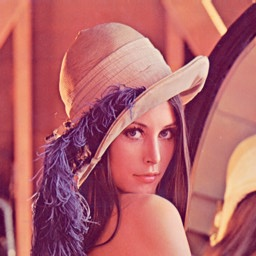

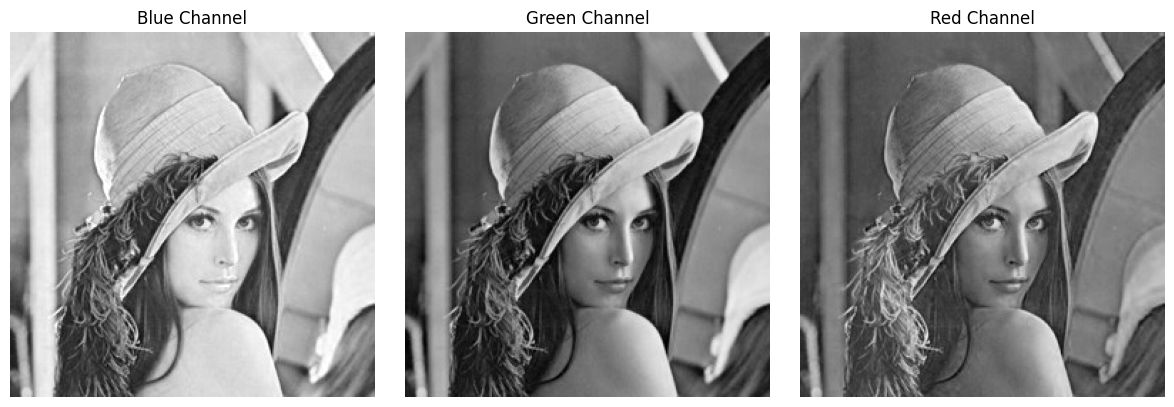

In [6]:
# define quantization tables
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

# read an image and show it
url = "http://www.lenna.org/len_std.jpg"

# url = "https://www.hlevkin.com/hlevkin/TestImages/baboon.bmp"
imgOriginal= load_from_url(url)
show(imgOriginal)

#TODO: show different channels
show_image_channels(imgOriginal,"gray")

In [7]:
# For students
# TODO: Write your 'main' code
# convert color image into gray image (or image in YCrCb space)
def convert_to_gray(img:np.ndarray):
    b_channel, g_channel, r_channel = cv2.split(img)
    height, width = img.shape[:2]
    Y = np.zeros((height, width), dtype=np.uint8)
    for i in range(height) :
        for j in range(width) :
            
            Y [i,j] =  0.299*r_channel[i,j] + 0.587*g_channel[i,j] - 0.114*b_channel[i,j]
    return Y
    

(256, 256) L None 0 255


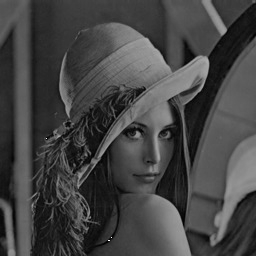

In [8]:
gray_img = convert_to_gray(imgOriginal)
show(gray_img)

(256, 256) RGB None 20 239


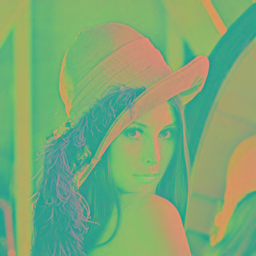

In [9]:
    
# This is just an example of coding, you can make your code differently

# ADVICE: create an other 'Code cell' and write/test your code gradually there
# since the code given here is not exectable yet

img = cv2.cvtColor(imgOriginal, cv2.COLOR_RGB2YCrCb)
# color
# First, you can work with only gray images for simplicity


width = len(img[0])
height = len(img)

#
img_gray = np.zeros((height, width), np.float32) + img[:, :, 0]
#

#show img_gray
show(img)

In [13]:
#Decoupage en Bloc de 8
blockSize = 8 
BLOCK_SIZE = blockSize
def split_into_blocks(img: np.ndarray, block_size: int = blockSize):
    """
    Découpe l'image en blocs 8x8.
    """
    height, width = img.shape
    blocks = []
    
    # Ajuster la taille de l'image pour être un multiple de 8
    padded_height = (height // block_size + 1) * block_size if height % block_size != 0 else height
    padded_width = (width // block_size + 1) * block_size if width % block_size != 0 else width
    
    padded_img = np.zeros((padded_height, padded_width), dtype=np.uint8)
    padded_img[:height, :width] = img  # Compléter avec des zéros
    
    for i in range(0, padded_height, block_size):
        for j in range(0, padded_width, block_size):
            blocks.append(padded_img[i:i+block_size, j:j+block_size])
    
    return blocks, padded_height, padded_width
blocks, padded_height, padded_width= split_into_blocks(img_gray, block_size=BLOCK_SIZE)
print(blocks)

[array([[161, 161, 162, 162, 163, 162, 160, 158],
       [161, 161, 161, 162, 162, 160, 158, 157],
       [161, 161, 161, 160, 160, 159, 157, 155],
       [159, 159, 159, 159, 159, 158, 156, 155],
       [157, 157, 157, 157, 158, 158, 157, 156],
       [156, 156, 156, 156, 157, 157, 157, 156],
       [157, 156, 156, 156, 156, 156, 156, 155],
       [157, 157, 156, 156, 156, 156, 155, 154]], dtype=uint8), array([[158, 159, 157, 156, 157, 156, 154, 156],
       [156, 158, 156, 155, 156, 155, 154, 156],
       [155, 156, 155, 154, 156, 155, 154, 156],
       [154, 156, 154, 153, 155, 154, 153, 155],
       [155, 157, 154, 153, 154, 153, 151, 153],
       [156, 157, 155, 153, 155, 153, 152, 153],
       [156, 157, 155, 154, 155, 154, 153, 155],
       [155, 157, 155, 154, 156, 155, 154, 156]], dtype=uint8), array([[156, 158, 161, 164, 167, 169, 172, 174],
       [155, 158, 161, 164, 167, 169, 172, 173],
       [154, 157, 160, 164, 167, 169, 171, 173],
       [153, 156, 160, 164, 167, 170, 

In [15]:
#Application de la transformée en Cosinus
def apply_dct(block):
    """
    Applique la DCT 2D à un bloc 8x8 après centrage.
    """
    centered_block = block.astype(np.float32) - 128  # Centrage
    return cv2.dct(centered_block)
for i in blocks :
    print(apply_dct(i))

[[ 2.40000000e+02  5.84451437e+00 -4.59618378e+00  2.91466904e+00
  -4.99999940e-01 -1.93665102e-01  9.61536076e-03  4.28777218e-01]
 [ 1.47797155e+01  2.77225995e+00 -3.32556653e+00  2.46134907e-01
   2.30244443e-01 -3.27475548e-01  2.22152516e-01  2.51708776e-01]
 [ 2.78806114e+00  2.45196417e-01 -3.01776558e-01  1.38892516e-01
   1.74927205e-01  2.07867354e-01 -1.25000015e-01 -4.87726070e-02]
 [ 3.25551152e-01 -4.31314898e+00  2.85877079e-01  1.09375671e-01
   6.19326392e-03  1.56037748e-01  6.68077823e-03  4.19494122e-01]
 [ 2.50005662e-01 -4.04290766e-01 -4.61939573e-01  2.97987312e-01
  -2.49999985e-01 -3.14171165e-01  1.91341698e-01 -1.55076340e-01]
 [ 5.20837344e-02  6.10835612e-01  1.09655626e-01 -2.07388792e-02
  -2.34262913e-01  4.03187394e-01  2.96208471e-01  2.34947726e-01]
 [ 1.98138997e-01  4.87723723e-02  1.24999940e-01  2.07867429e-01
  -8.84251297e-01 -1.38892576e-01  5.17766848e-02  2.45196253e-01]
 [ 2.76250988e-01  7.49320090e-02  4.06598568e-01  2.79378682e-01
  -

In [17]:
#Application de la quantification
def quantize(block, quant_matrix):
    """
    Applique la quantification à un bloc 8x8.
    """
    return np.round(block / quant_matrix).astype(np.int32)
for i in blocks :
    print(quantize(i, qY))

[[10 15 16 10  7  4  3  3]
 [13 13 12  9  6  3  3  3]
 [12 12 10  7  4  3  2  3]
 [11  9  7  5  3  2  2  2]
 [ 9  7  4  3  2  1  2  2]
 [ 6  4  3  2  2  2  1  2]
 [ 3  2  2  2  2  1  1  2]
 [ 2  2  2  2  1  2  2  2]]
[[10 14 16 10  7  4  3  3]
 [13 13 11  8  6  3  3  3]
 [11 12 10  6  4  3  2  3]
 [11  9  7  5  3  2  2  2]
 [ 9  7  4  3  2  1  1  2]
 [ 6  4  3  2  2  1  1  2]
 [ 3  2  2  2  2  1  1  2]
 [ 2  2  2  2  1  2  1  2]]
[[10 14 16 10  7  4  3  3]
 [13 13 12  9  6  4  3  3]
 [11 12 10  7  4  3  2  3]
 [11  9  7  6  3  2  2  3]
 [ 8  7  4  3  2  2  2  2]
 [ 6  4  3  3  2  2  2  2]
 [ 3  2  2  2  2  1  1  2]
 [ 2  2  2  2  2  2  2  2]]
[[11 15 17 10  6  4  3  2]
 [14 14 12  8  6  3  2  2]
 [12 13 10  7  4  2  2  2]
 [12 10  8  5  3  2  2  2]
 [10  8  4  3  2  1  1  1]
 [ 7  5  3  2  2  1  1  1]
 [ 3  3  2  2  1  1  1  1]
 [ 2  2  2  2  1  1  1  1]]
[[6 8 9 6 4 3 2 2]
 [8 8 7 5 4 2 2 2]
 [7 7 6 4 2 2 2 2]
 [7 5 4 3 2 1 1 2]
 [5 4 2 2 1 1 1 1]
 [4 3 2 1 1 1 1 1]
 [2 1 1 1 1 1 1 1]

In [18]:
ZZ_Blk = np.zeros(blockSize * blockSize) #1D

vRLC = []

size_vRLC = 0

splits, padded_height, padded_width = split_into_blocks(img_gray)

In [29]:
# Boucle sur tous les blocs de l'image
for block in splits:
        #block = img_gray[i * BLOCK_SIZE:(i + 1) * BLOCK_SIZE, j * BLOCK_SIZE:(j + 1) * BLOCK_SIZE]  # Extraction du bloc

        # Appliquer la DCT
        dct_block = apply_dct(block)

        # Appliquer la quantification
        quantized_block = quantize(dct_block, qY)

        # Appliquer le parcours en zigzag
        ZZ_Blk = zigzag(quantized_block)  # Convertit le bloc en une séquence 1D

        # Appliquer l'encodage Run-Length
        RLC_Blk = rlencode(ZZ_Blk, symbol=0, escape=257)

        # Ajouter à la liste principale
        vRLC.extend(RLC_Blk)
print(vRLC)

[np.float64(15.0), np.float64(1.0), np.float64(1.0), np.float64(257.0), np.float64(61.0), np.float64(13.0), np.float64(1.0), np.float64(257.0), np.float64(62.0), np.float64(18.0), np.float64(-4.0), np.float64(257.0), np.float64(2.0), np.float64(-1.0), np.float64(-1.0), np.float64(257.0), np.float64(2.0), np.float64(1.0), np.float64(257.0), np.float64(55.0), np.float64(10.0), np.float64(15.0), np.float64(2.0), np.float64(257.0), np.float64(2.0), np.float64(-4.0), np.float64(1.0), np.float64(257.0), np.float64(57.0), np.float64(-15.0), np.float64(-3.0), np.float64(1.0), np.float64(257.0), np.float64(2.0), np.float64(1.0), np.float64(1.0), np.float64(257.0), np.float64(57.0), np.float64(-11.0), np.float64(257.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(-1.0), np.float64(257.0), np.float64(59.0), np.float64(-9.0), np.float64(-3.0), np.float64(1.0), np.float64(257.0), np.float64(2.0), np.float64(1.0), np.float64(257.0), np.float64(58.0), np.float64(-2.0), np.float64(-2

In [34]:
mat_table: dict = construct_huffman_table(vRLC)
mat_encoded: str = encode_huffman(vRLC, mat_table)


In [35]:
'''cr_mat_table = construct_huffman_table(rRLC)
cr_mat_encoded = encode_huffman(rRLC, cr_mat_table)

cb_mat_table = construct_huffman_table(bRLC)
cb_mat_encoded = encode_huffman(bRLC, cb_mat_table)'''

# Huffman table display
counts = count_symbols(vRLC)
display_huffman_table(vRLC, bintree_to_table(compute_huffman_tree(vRLC, counts)))

 Symbol	 Code	         Count	Frequency
`257.0`	10215	            01	    21.0%
  `1.0`	 9945	            00	   20.44%
 `-1.0`	 6927	           101	   14.24%
  `2.0`	 3333	          1100	    6.85%
  `3.0`	 2049	         11101	    4.21%
 `-2.0`	 1980	         11011	    4.07%
 `-3.0`	 1245	         10000	    2.56%
  `4.0`	 1164	        111110	    2.39%
  `5.0`	  801	        100111	    1.65%
 `-4.0`	  756	        100100	    1.55%
  `6.0`	  564	       1111001	    1.16%
  `7.0`	  552	       1111000	    1.13%
 `-5.0`	  492	       1110001	    1.01%
 `-6.0`	  387	       1001011	     0.8%
 `-7.0`	  300	      11110111	    0.62%
  `9.0`	  300	      11111100	    0.62%
  `8.0`	  291	      11110110	     0.6%
 `61.0`	  222	      11010101	    0.46%
 `-8.0`	  219	      11010011	    0.45%
 `49.0`	  210	      11010000	    0.43%
 `11.0`	  207	      10011011	    0.43%
 `58.0`	  195	      10011001	     0.4%
 `13.0`	  192	      10011000	    0.39%
 `10.0`	  186	      10010100	    0.38%
 `57.0`	  183	      10001

In [ ]:
# For testing a block, all steps (notably zigzag, rlc) are OK


**Compute compression rates at different stages**

In [45]:
# number of bits in original image
H, W = gray_img.shape
print("H;",H,", W:",W)
size_yRLC = len(vRLC)

print("Number of bits (original):", gray_img.size)
print("Number of elelemnts (yRLC):", size_yRLC)
print("Number of bits (encoded):", len(mat_encoded))
print("Compression ratio:", img.size/len(mat_encoded))

H; 256 , W: 256
Number of bits (original): 65536
Number of elelemnts (yRLC): 48651
Number of bits (encoded): 339729
Compression ratio: 0.5787200974894695


**Decodage**

In [ ]:
# Huffman decoding
decoded = decode_huffman...
print(len(decoded))

15256


In [ ]:
print(decoded)

[  5.   1.   2. ...   1. 257.  46.]


In [ ]:
decoded - yRLC

array([0., 0., 0., ..., 0., 0., 0.])